In [1]:
"""
Name: example_prob_model_atten_test.ipynb
Authors: Stephan Meighen-Berger
Example how to use the probabilistic model to get an estimate of the attenuation length
"""

'\nName: example_prob_model_atten_test.ipynb\nAuthors: Stephan Meighen-Berger\nExample how to use the probabilistic model to get an estimate of the attenuation length\n'

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
import scipy.special as sps
from matplotlib.pyplot import cm

In [3]:
# picture path
PICS = '../pics/'

In [4]:
# Plotting standards
std_size = 10.
fontsize = 20.
lw=1.
h_length=1.

In [5]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [6]:
number_of_files = list(range(1001))[1:]
number_of_peaks_base = []
peak_heights_base = []
peak_widths_base = []
res_dic_list = []
factors_arr = [1e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1,
               6e-1, 7e-1, 8e-1, 9e-1,
               9.5e-1, 9.9e-1, 1.01e0, 1.05e0,
               1.1e0, 1.2e0, 1.3e0, 1.4e0, 1.5e0,
               1.6e0, 1.7e0, 1.8e0, 1.9e0,
               2e0, 5e0, 1e1]
# factors_arr = [1e-2, 1e-1, 5e-1, 7e-1, 9e-1,
#                1.1e0, 1.3e0, 1.5e0, 1.9e0, 1e1]
for number in number_of_files:
    try:
        res_dic = pickle.load(open("results_v3\\comp_sim_v3_%d.p" %number, "rb" ))
        if list(res_dic.keys()) != factors_arr:
            continue
        res_dic_list.append(res_dic)
        base = pickle.load(open("results_v3\\base_v3_sim_%d.p" %number, "rb"))
        number_of_peaks_base.append(base[0])
        peak_heights_base.append(base[1])
        peak_widths_base.append(base[2])
    except:
        continue
print("Successful simulation runs: %d" % len(res_dic_list))

Successful simulation runs: 1000


In [7]:
bins_heights = np.logspace(2., 6., 41)
bins_width = np.linspace(0., 10., 100)

In [8]:
n_peaks_base_mean = np.mean(number_of_peaks_base)
n_peaks_base_std = np.std(number_of_peaks_base)
heights_counts = []
widths_counts = []
for run in peak_heights_base:
    for peak_height in run:
        hist, bin_edges = np.histogram(peak_height, bins=bins_heights)
        heights_counts.append(hist)
for run in peak_widths_base:
    for peak_width in run:
        hist, bin_edges = np.histogram(peak_width, bins=bins_width)
        widths_counts.append(hist)
heights_counts_mean = np.sum(heights_counts, axis=0)
widths_counts_mean = np.sum(widths_counts, axis=0)

In [9]:
mean_vals_peaks = {}
mean_vals_heights = {}
mean_vals_widths = {}
for id_fac, factors in enumerate(factors_arr):
    heights = []
    widths = []
    for res_dic in res_dic_list:
        mean_vals_peaks[factors] = np.mean(res_dic[factors][0])
        for peak_height in res_dic[factors][1]:
            hist, bin_edges = np.histogram(peak_height, bins=bins_heights)
            heights.append(hist)
        for peak_width in res_dic[factors][2]:
            hist, bin_edges = np.histogram(peak_width, bins=bins_width)
            widths.append(hist)
    mean_vals_heights[factors] = np.sum(heights, axis=0)
    mean_vals_widths[factors] = np.sum(widths, axis=0)

In [10]:
# print(n_peaks_base_mean)
# for factors in factors_arr:
#     print(mean_vals_peaks[factors])

In [11]:
def pdf(x, mu, sigma):
    """pdf of mormal distribution"""
    return (np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi)))
def pdf_gamma(x, shape, scale):
    """gamma distro function"""
    return x**(shape-1.)*(np.exp(-x/scale) / (sps.gamma(shape)*scale**shape))

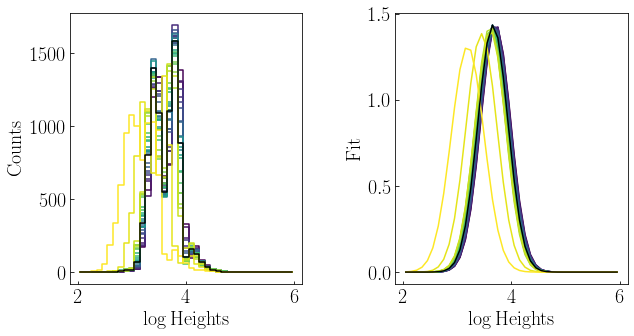

In [12]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(std_size, std_size * 4. / 8.), sharex=True)
color=iter(cm.viridis(np.linspace(0,1,len(factors_arr))))
for id_fac, factors in enumerate(factors_arr):
    c=next(color)
    ax1.step(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
             mean_vals_heights[factors], label=r'$%.1e$' %factors, color=c)
ax1.step(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
         heights_counts_mean, color='k', label=r'$True$')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\log\mathrm{Heights}$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Counts}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# Norm fits
color=iter(cm.viridis(np.linspace(0,1,len(factors_arr))))
for id_fac, factors in enumerate(factors_arr):
    c=next(color)
    normalized = (mean_vals_heights[factors] /
                  np.trapz(mean_vals_heights[factors], x=np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])))
                 )
    popt, pcov = curve_fit(pdf, np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
                           normalized, p0=[1, 1])
    yr = pdf(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])), *popt)
    ax2.plot(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
             yr, color=c)
normalized = (heights_counts_mean /
              np.trapz(heights_counts_mean, x=np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])))
             )
popt, pcov = curve_fit(pdf, np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
                       normalized, p0=[1, 1])
yr = pdf(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])), *popt)
ax2.plot(np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
         yr, color='k')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_xlabel(r'$\log\mathrm{Heights}$', fontsize=fontsize)
ax2.set_ylabel(r'$\mathrm{Fit}$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
# lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(1., +1.4),
#                   ncol=5, fontsize=fontsize, handlelength=h_length,
#                   fancybox=True, frameon=False)
# ax1.set_ylim(1e0, 300)
# ax1.set_xlim(1e3, 1e6)
plt.subplots_adjust(wspace = 0.4, hspace = 0.)
figure.savefig(PICS + "Height_Distro_v4.png",
               bbox_inches='tight')
plt.show()

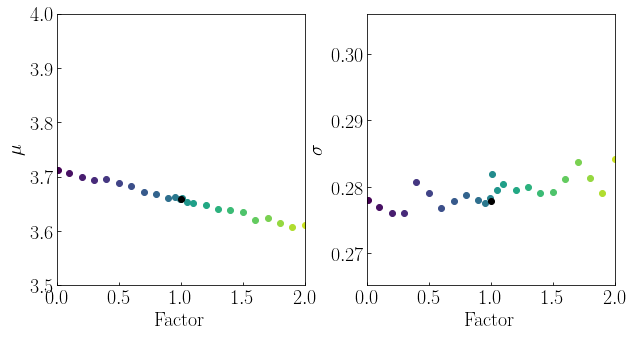

In [13]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(std_size, std_size * 4. / 8.), sharex=False)
# Norm fits
color=iter(cm.viridis(np.linspace(0,1,len(factors_arr))))
for id_fac, factors in enumerate(factors_arr):
    c=next(color)
    normalized = (mean_vals_heights[factors] /
                  np.trapz(mean_vals_heights[factors], x=np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])))
                 )
    popt, pcov = curve_fit(pdf, np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
                           normalized, p0=[1, 1])
    ax1.scatter(factors, popt[0], label=r'$%.1e$' %factors, color=c)
    ax2.scatter(factors, popt[1], color=c)
normalized = (heights_counts_mean /
              np.trapz(heights_counts_mean, x=np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])))
             )
popt, pcov = curve_fit(pdf, np.log10(np.sqrt(bins_heights[1:] * bins_heights[:-1])),
                       normalized, p0=[1, 1])
ax1.scatter(1., popt[0], color='k', label=r'$True$')
ax2.scatter(1., popt[1], color='k')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{Factor}$', fontsize=fontsize)
ax1.set_ylabel(r'$\mu$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_xlabel(r'$\mathrm{Factor}$', fontsize=fontsize)
ax2.set_ylabel(r'$\sigma$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
# h, l = ax1.get_legend_handles_labels()
# lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(1., +1.4),
#                   ncol=5, fontsize=fontsize, handlelength=h_length,
#                   fancybox=True, frameon=False)
ax1.set_ylim(3.5, 4.)
ax1.set_xlim(0., 2.)
# ax2.set_ylim(0.55, 0.65)
ax2.set_xlim(0., 2.)
plt.subplots_adjust(wspace = 0.25, hspace = 0.)
figure.savefig(PICS + "Para_Vals_v4.png",
               bbox_inches='tight')
plt.show()

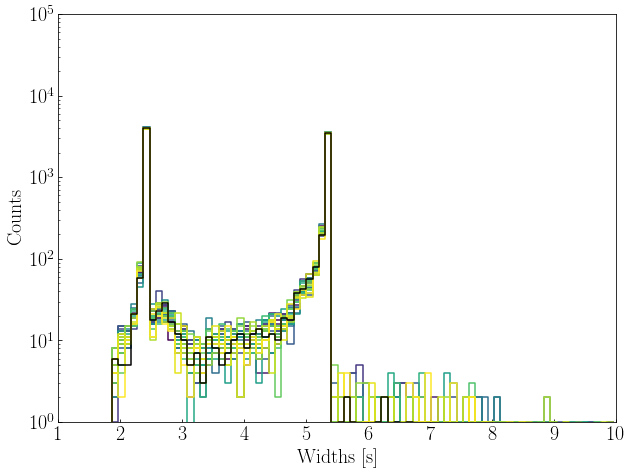

In [14]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
color=iter(cm.viridis(np.linspace(0,1,len(factors_arr))))
for id_fac, factors in enumerate(factors_arr):
    c=next(color)
    ax1.step((bins_width[1:] + bins_width[:-1])/2, mean_vals_widths[factors], color=c)
ax1.step((bins_width[1:] + bins_width[:-1])/2, widths_counts_mean,
         color='k')
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\mathrm{Widths}\;[\mathrm{s}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Counts}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.0),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(1e0, 1e5)
ax1.set_xlim(1., 10)
figure.savefig(PICS + "Width_Distro_v4.png",
               bbox_inches='tight')
plt.show()